<a href="https://colab.research.google.com/github/ahmedsiradj/Notes/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/Test_Data_CSV.csv')

In [3]:
df.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,1,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,1,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,1,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,1,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5


In [4]:
print(df.shape)

(39414, 7)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39414 entries, 0 to 39413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Data_No                39414 non-null  int64  
 1   Differential_pressure  39414 non-null  float64
 2   Flow_rate              39414 non-null  float64
 3   Time                   39414 non-null  float64
 4   Dust_feed              39414 non-null  float64
 5   Dust                   39414 non-null  object 
 6   RUL                    39414 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.1+ MB


In [6]:
print(df.dtypes)

Data_No                    int64
Differential_pressure    float64
Flow_rate                float64
Time                     float64
Dust_feed                float64
Dust                      object
RUL                      float64
dtype: object


In [7]:
print(df.duplicated().sum())

0


In [8]:
df = df.drop(['Dust','Data_No','Time'], axis=1)

In [9]:
df = df.dropna()

In [10]:
df= df.drop_duplicates()

In [11]:
print(df.isnull().sum())
print("------------------------")
print(df.duplicated().sum())

Differential_pressure    0
Flow_rate                0
Dust_feed                0
RUL                      0
dtype: int64
------------------------
0


# Feature Engineering

In [12]:
def add_features(df, window_size=10):
    # Rolling mean and std for Differential_pressure and Flow_rate
    df['roll_mean_pressure'] = df['Differential_pressure'].rolling(window=window_size).mean()
    df['roll_std_pressure'] = df['Differential_pressure'].rolling(window=window_size).std()
    df['roll_mean_flow'] = df['Flow_rate'].rolling(window=window_size).mean()
    df['roll_std_flow'] = df['Flow_rate'].rolling(window=window_size).std()

    # Difference between consecutive values (trend)
    df['pressure_diff'] = df['Differential_pressure'].diff()
    df['flow_diff'] = df['Flow_rate'].diff()

    # Fill NaNs created by rolling operations with backward fill
    df = df.bfill()

    return df

# Apply feature engineering
df_featured = add_features(df, window_size=10)


# Normalization

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_df = df_featured.copy()
scaled_df = scaler.fit_transform(scaled_df)
df_featured = pd.DataFrame(scaled_df, columns=df.columns)



# Time window creation

In [14]:
import numpy as np
def create_time_windows(data, target_col, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data.iloc[i:i+window_size]  # Window data
        X.append(window.drop(columns=[target_col]).values)  # Features within window
        y.append(data[target_col].iloc[i+window_size - 1])  # RUL target at window's end
    return np.array(X), np.array(y)

# Example usage
window_size = 50  # Define the number of time steps per sequence
X, y = create_time_windows(df_featured, target_col='RUL', window_size=window_size)


# Train/Validation/Test Splitting

In [15]:
# Define train, validation, test split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Split based on time order
train_index = int(len(X) * train_size)
val_index = int(len(X) * (train_size + val_size))

X_train, y_train = X[:train_index], y[:train_index]
X_val, y_val = X[train_index:val_index], y[train_index:val_index]
X_test, y_test = X[val_index:], y[val_index:]


# Model Training

## LSTM Autoencoder Model

In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# Define LSTM Autoencoder model
def create_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(RepeatVector(input_shape[0]))  # Replicate for decoding
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse',metrics=['mae', 'mse'])
    return model

# Create model and train
input_shape = (window_size, X_train.shape[2])
lstm_autoencoder = create_lstm_autoencoder(input_shape)
lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=64,verbose=0, validation_data=(X_val, X_val))





/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
print(dict(zip(lstm_autoencoder.metrics_names, lstm_autoencoder_history.history['loss'])))

{'loss': 0.02556677721440792, 'compile_metrics': 0.0015532014658674598}


In [18]:
lstm_autoencoder.save("lstm_autoencoder_model.h5")

# Accuracy Metrics

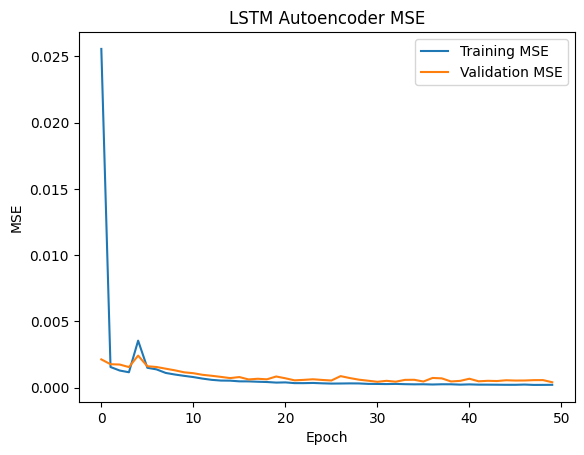

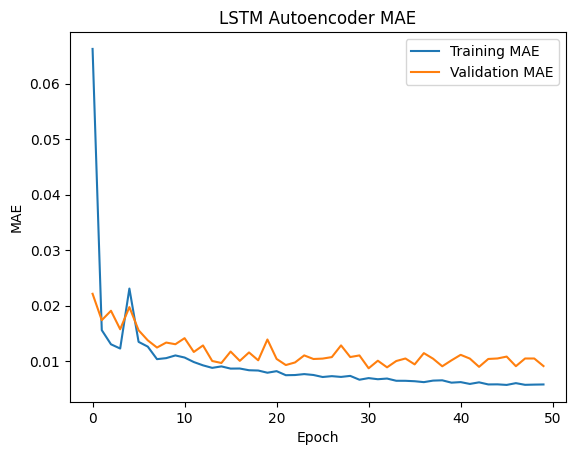

In [19]:
import matplotlib.pyplot as plt
plt.plot(lstm_autoencoder_history.history['loss'], label='Training MSE')
plt.plot(lstm_autoencoder_history.history['val_loss'], label='Validation MSE')
plt.title('LSTM Autoencoder MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(lstm_autoencoder_history.history['mae'], label='Training MAE')
plt.plot(lstm_autoencoder_history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Autoencoder MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Resources Metrics

In [20]:
import time
import os
import psutil
import tensorflow as tf

# Measure inference time
start_time = time.time()
_ = lstm_autoencoder.predict(X_test)
inference_time = time.time() - start_time

# Measure memory usage (current process memory)
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / 1024 ** 2  # Convert to MB

# Model size
model_size = os.path.getsize("lstm_autoencoder_model.h5") / 1024 ** 2  # Save and measure size in MB

print(f"Inference Time: {inference_time} seconds")
print(f"Memory Usage: {memory_usage} MB")
print(f"Model Size: {model_size} MB")


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Inference Time: 7.194521188735962 seconds
Memory Usage: 1639.296875 MB
Model Size: 0.8032913208007812 MB


# ----------------------------------------------------------------------------------------------------------------------------------

# Bidirectional LSTM Model

In [21]:
from tensorflow.keras.layers import Bidirectional

# Define Bidirectional LSTM model
def create_bidirectional_lstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
    model.add(Dense(1, activation='linear'))  # RUL as a regression output
    model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
    return model

# Create model and train
bidirectional_lstm = create_bidirectional_lstm(input_shape)
bidirectional_lstm_history = bidirectional_lstm.fit(X_train, y_train, epochs=50, batch_size=64,verbose=0, validation_data=(X_val, y_val))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
print(dict(zip(bidirectional_lstm.metrics_names, bidirectional_lstm_history.history['loss'])))

{'loss': 0.005736441817134619, 'compile_metrics': 0.0026481447275727987}


In [23]:
bidirectional_lstm.save('bidirectional_lstm_model.h5')

# Accuracy Metrics

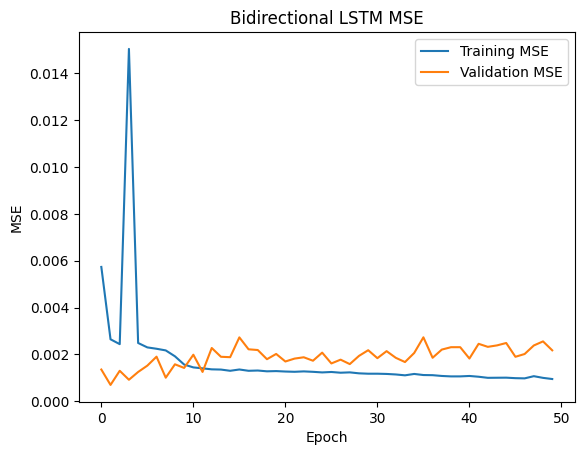

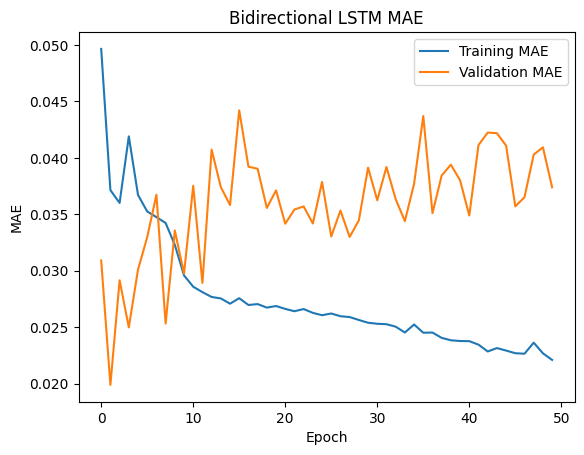

In [24]:
import matplotlib.pyplot as plt
plt.plot(bidirectional_lstm_history.history['loss'], label='Training MSE')
plt.plot(bidirectional_lstm_history.history['val_loss'], label='Validation MSE')
plt.title('Bidirectional LSTM MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(bidirectional_lstm_history.history['mae'], label='Training MAE')
plt.plot(bidirectional_lstm_history.history['val_mae'], label='Validation MAE')
plt.title('Bidirectional LSTM MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Resource Metrics

In [25]:
import time
import os
import psutil
import tensorflow as tf

# Measure inference time
start_time = time.time()
_ = bidirectional_lstm.predict(X_test)
inference_time = time.time() - start_time

# Measure memory usage (current process memory)
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / 1024 ** 2  # Convert to MB

# Model size
model_size = os.path.getsize("bidirectional_lstm_model.h5") / 1024 ** 2  # Save and measure size in MB

print(f"Inference Time: {inference_time} seconds")
print(f"Memory Usage: {memory_usage} MB")
print(f"Model Size: {model_size} MB")


185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Inference Time: 5.206999778747559 seconds
Memory Usage: 1881.90234375 MB
Model Size: 0.9577484130859375 MB


# --------------------------------------------------------------------------------------------------------------------

# Optimization

# Quantization

In [26]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.0 MB/s eta 0:00:00


In [27]:
import tensorflow_model_optimization as tfmot
print(tfmot.__version__)  # To check if the package is installed correctly


0.8.0


#### Method

In [28]:
import tensorflow as tf

def quantize_model(model, bits=8):
    """Quantize model parameters to reduced precision"""
    scale = (2 ** bits) - 1

    if hasattr(model, 'mean') and hasattr(model, 'var'):
        # Quantize Naive Bayes parameters
        model.mean = np.round(model.mean * scale) / scale
        model.var = np.round(model.var * scale) / scale

    return model

# Apply quantization to both models





## LSTM Autoencoder

In [29]:
quantized_lstm_autoencoder = quantize_model(lstm_autoencoder)
quantized_lstm_autoencoder_history = quantized_lstm_autoencoder.fit(X_train, X_train, epochs=50,verbose=0, batch_size=64, validation_data=(X_val, X_val))

In [30]:
print(dict(zip(quantized_lstm_autoencoder.metrics_names, quantized_lstm_autoencoder_history.history['loss'])))

{'loss': 0.0001904238306451589, 'compile_metrics': 0.0002614807744976133}


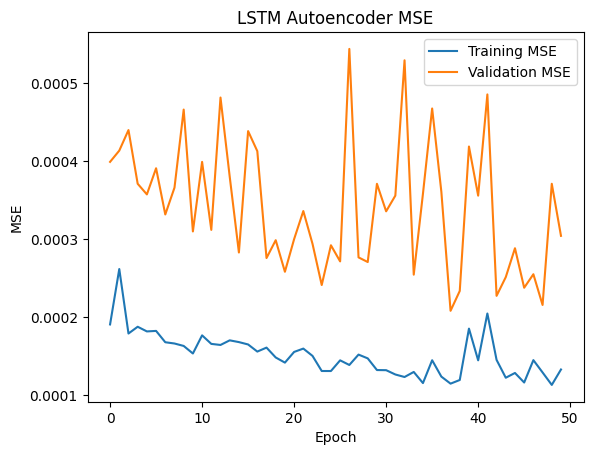

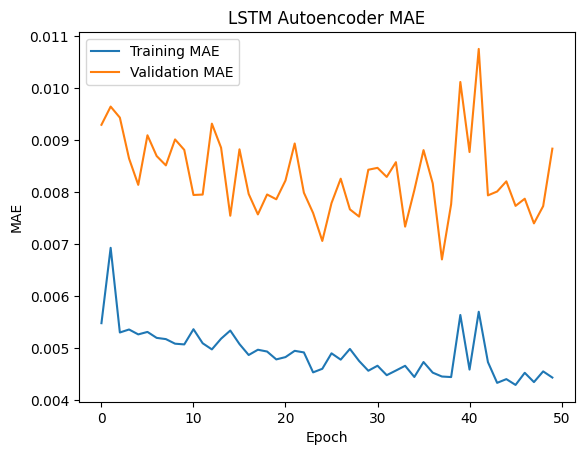

In [31]:
import matplotlib.pyplot as plt
plt.plot(quantized_lstm_autoencoder_history.history['loss'], label='Training MSE')
plt.plot(quantized_lstm_autoencoder_history.history['val_loss'], label='Validation MSE')
plt.title('LSTM Autoencoder MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(quantized_lstm_autoencoder_history.history['mae'], label='Training MAE')
plt.plot(quantized_lstm_autoencoder_history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Autoencoder MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [32]:
quantized_lstm_autoencoder.save('quantized_lstm_autoencoder_model.h5')

In [33]:
import time
import os
import psutil
import tensorflow as tf

# Measure inference time
start_time = time.time()
_ = quantized_lstm_autoencoder.predict(X_test)
inference_time = time.time() - start_time

# Measure memory usage (current process memory)
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / 1024 ** 2  # Convert to MB

# Model size
model_size = os.path.getsize("quantized_lstm_autoencoder_model.h5") / 1024 ** 2  # Save and measure size in MB

print(f"Inference Time: {inference_time} seconds")
print(f"Memory Usage: {memory_usage} MB")
print(f"Model Size: {model_size} MB")

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Inference Time: 1.8469154834747314 seconds
Memory Usage: 1949.05078125 MB
Model Size: 0.8032913208007812 MB


# Bidirectional LSTM

In [34]:
quantized_bidirectional_lstm = quantize_model(bidirectional_lstm)
quantized_bidirectional_lstm_history = quantized_bidirectional_lstm.fit(X_train, y_train, epochs=50,verbose=0, batch_size=64, validation_data=(X_val, y_val))

In [35]:
print(dict(zip(quantized_bidirectional_lstm.metrics_names, quantized_bidirectional_lstm_history.history['loss'])))

{'loss': 0.0009494724217802286, 'compile_metrics': 0.0009291970636695623}


In [36]:
quantized_bidirectional_lstm.save('quantized_bidirectional_lstm_model.h5')

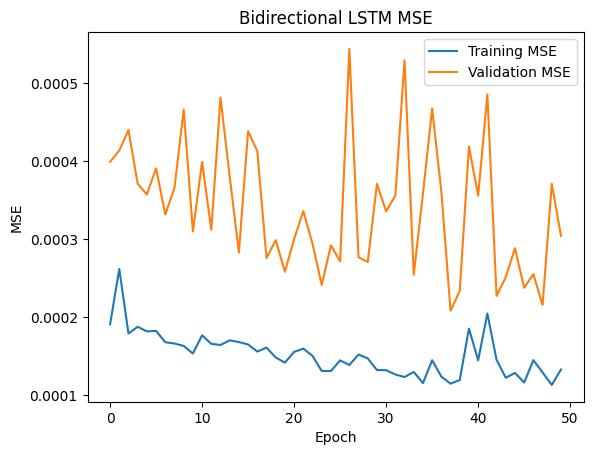

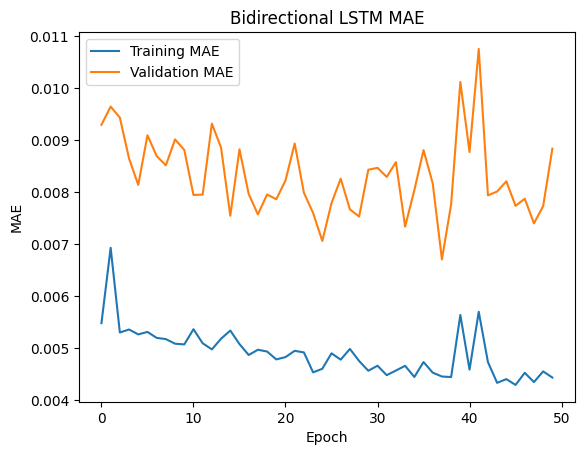

In [37]:
import matplotlib.pyplot as plt
plt.plot(quantized_lstm_autoencoder_history.history['loss'], label='Training MSE')
plt.plot(quantized_lstm_autoencoder_history.history['val_loss'], label='Validation MSE')
plt.title('Bidirectional LSTM MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(quantized_lstm_autoencoder_history.history['mae'], label='Training MAE')
plt.plot(quantized_lstm_autoencoder_history.history['val_mae'], label='Validation MAE')
plt.title('Bidirectional LSTM MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [38]:
import time
import os
import psutil
import tensorflow as tf

# Measure inference time
start_time = time.time()
_ = quantized_bidirectional_lstm.predict(X_test)
inference_time = time.time() - start_time

# Measure memory usage (current process memory)
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / 1024 ** 2  # Convert to MB

# Model size
model_size = os.path.getsize("quantized_bidirectional_lstm_model.h5") / 1024 ** 2  # Save and measure size in MB

print(f"Inference Time: {inference_time} seconds")
print(f"Memory Usage: {memory_usage} MB")
print(f"Model Size: {model_size} MB")

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Inference Time: 2.1407101154327393 seconds
Memory Usage: 1930.12109375 MB
Model Size: 0.9577484130859375 MB


# Knowledge Distallation

# LSTM Autoencoder

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


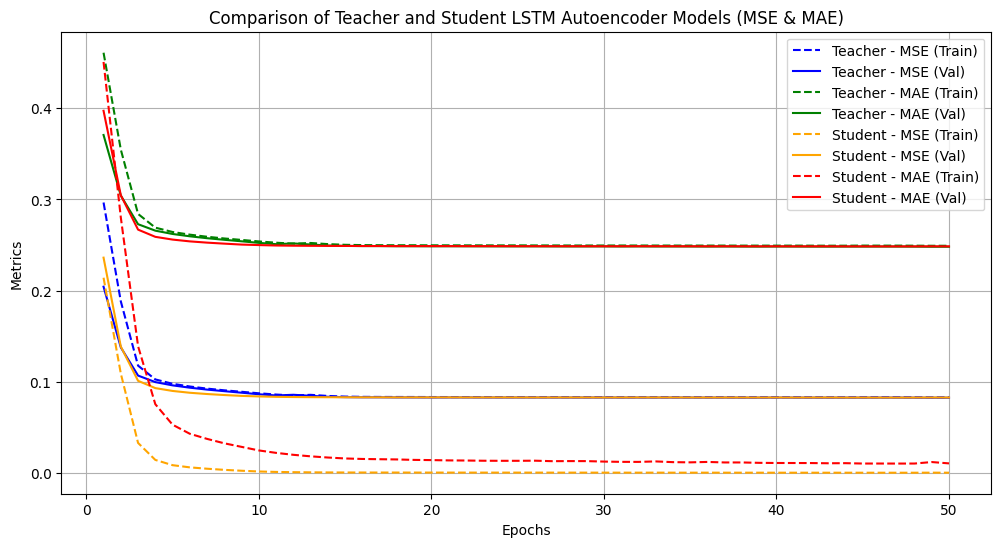

Teacher Model Evaluation (Validation): {'loss': 0.08244618773460388, 'compile_metrics': 0.2481016367673874}
Student Model Evaluation (Validation): {'loss': 0.08268029242753983, 'compile_metrics': 0.24853412806987762}


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# Placeholder data setup for demonstration (replace these with your real data)
window_size = 50
features = 9
X_train = np.random.random((1000, window_size, features))
X_val = np.random.random((200, window_size, features))

# Define LSTM Autoencoder model (Teacher)
def create_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(RepeatVector(input_shape[0]))  # Replicate for decoding
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

# Teacher Model
input_shape = (window_size, features)
teacher_model = create_lstm_autoencoder(input_shape)
teacher_history = teacher_model.fit(
    X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val), verbose=0
)

# Define Student Model (smaller)
def create_student_autoencoder(input_shape):
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(RepeatVector(input_shape[0]))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

# Generate soft labels from the teacher model
teacher_predictions = teacher_model.predict(X_train)

# Train the Student Model on soft labels
student_model = create_student_autoencoder(input_shape)
student_history = student_model.fit(
    X_train, teacher_predictions, epochs=50, batch_size=64, validation_data=(X_val, X_val), verbose=0
)

# Evaluate both models
teacher_eval = teacher_model.evaluate(X_val, X_val, verbose=0)
student_eval = student_model.evaluate(X_val, X_val, verbose=0)

# Metrics plotting
epochs = range(1, 51)
plt.figure(figsize=(12, 6))

# Teacher metrics
plt.plot(epochs, teacher_history.history['mse'], label='Teacher - MSE (Train)', linestyle='--', color='blue')
plt.plot(epochs, teacher_history.history['val_mse'], label='Teacher - MSE (Val)', linestyle='-', color='blue')

plt.plot(epochs, teacher_history.history['mae'], label='Teacher - MAE (Train)', linestyle='--', color='green')
plt.plot(epochs, teacher_history.history['val_mae'], label='Teacher - MAE (Val)', linestyle='-', color='green')

# Student metrics
plt.plot(epochs, student_history.history['mse'], label='Student - MSE (Train)', linestyle='--', color='orange')
plt.plot(epochs, student_history.history['val_mse'], label='Student - MSE (Val)', linestyle='-', color='orange')

plt.plot(epochs, student_history.history['mae'], label='Student - MAE (Train)', linestyle='--', color='red')
plt.plot(epochs, student_history.history['val_mae'], label='Student - MAE (Val)', linestyle='-', color='red')

plt.title('Comparison of Teacher and Student LSTM Autoencoder Models (MSE & MAE)')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid()
plt.show()

# Print evaluation metrics
print("Teacher Model Evaluation (Validation):", dict(zip(teacher_model.metrics_names, teacher_eval)))
print("Student Model Evaluation (Validation):", dict(zip(student_model.metrics_names, student_eval)))


In [41]:
import time

def calculate_model_metrics(model, input_data):
    # Model size in MB
    trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(w.shape) for w in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    model_size_mb = (total_params * 4) / (1024**2)  # 4 bytes per parameter (float32)

    # Memory size during inference (approximation)
    memory_size_mb = model_size_mb * 2  # Parameters and intermediate tensors

    # Inference time for a single batch
    start_time = time.time()
    _ = model.predict(input_data, verbose=0)
    inference_time = time.time() - start_time

    return {
        "model_size_mb": model_size_mb,
        "memory_size_mb": memory_size_mb,
        "inference_time": inference_time
    }

# Calculate metrics for Teacher Model
teacher_metrics = calculate_model_metrics(teacher_model, X_val[:1])

# Calculate metrics for Student Model
student_metrics = calculate_model_metrics(student_model, X_val[:1])

print("Teacher Model Metrics:")
print(teacher_metrics)

print("\nStudent Model Metrics:")
print(student_metrics)


Teacher Model Metrics:
{'model_size_mb': 0.24832534790039062, 'memory_size_mb': 0.49665069580078125, 'inference_time': 2.249566078186035}

Student Model Metrics:
{'model_size_mb': 0.06558609008789062, 'memory_size_mb': 0.13117218017578125, 'inference_time': 2.758880138397217}


# Bidirectional LSTM


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


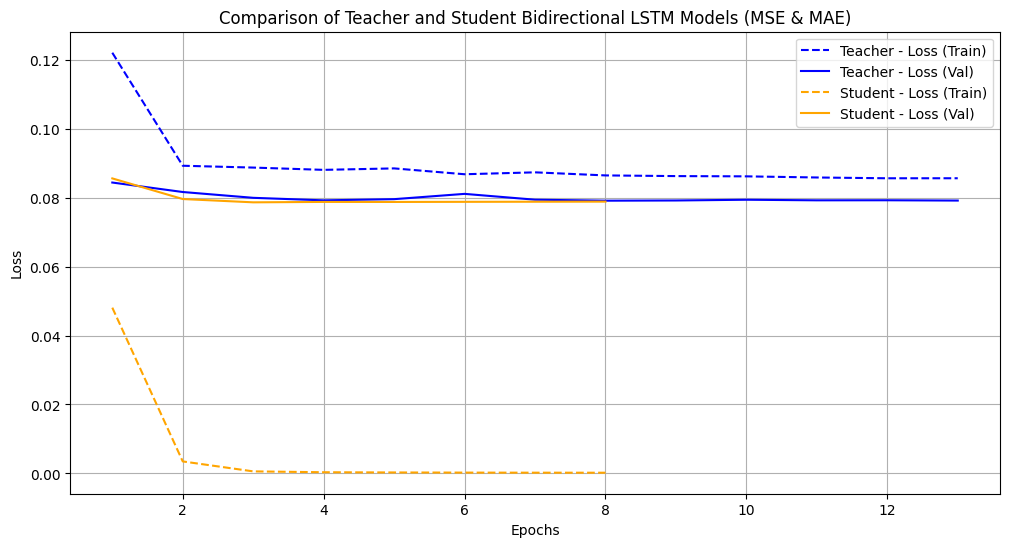

Teacher Model Evaluation (Validation): {'loss': 0.07911713421344757, 'compile_metrics': 0.07911713421344757}
Student Model Evaluation (Validation): {'loss': 0.07864055782556534, 'compile_metrics': 0.07864055782556534}


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data setup (replace with your real data)
X_train = np.random.random((1000, window_size, features))  # Input features
y_train = np.random.random(1000)  # Target (RUL values)
X_val = np.random.random((200, window_size, features))
y_val = np.random.random(200)

# Define Bidirectional LSTM Teacher Model
def create_teacher_bidirectional_lstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))
    model.add(Dense(1, activation='linear'))  # Regression output
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return model

# Define Bidirectional LSTM Student Model (Smaller)
def create_student_bidirectional_lstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return model

# Create and train Teacher model
teacher_model = create_teacher_bidirectional_lstm((window_size, features))
teacher_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]
teacher_history = teacher_model.fit(
    X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val),
    callbacks=teacher_callbacks, verbose=0
)

# Generate soft labels using the Teacher model
teacher_predictions = teacher_model.predict(X_train)

# Create and train Student model using soft labels
student_model = create_student_bidirectional_lstm((window_size, features))
student_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]
student_history = student_model.fit(
    X_train, teacher_predictions, epochs=50, batch_size=64, validation_data=(X_val, y_val),
    callbacks=student_callbacks, verbose=0
)

# Plot metrics for Teacher and Student models
epochs_teacher = range(1, len(teacher_history.history['loss']) + 1)
epochs_student = range(1, len(student_history.history['loss']) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_teacher, teacher_history.history['loss'], label='Teacher - Loss (Train)', linestyle='--', color='blue')
plt.plot(epochs_teacher, teacher_history.history['val_loss'], label='Teacher - Loss (Val)', linestyle='-', color='blue')
plt.plot(epochs_student, student_history.history['loss'], label='Student - Loss (Train)', linestyle='--', color='orange')
plt.plot(epochs_student, student_history.history['val_loss'], label='Student - Loss (Val)', linestyle='-', color='orange')
plt.title('Comparison of Teacher and Student Bidirectional LSTM Models (MSE & MAE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluate models
teacher_eval = teacher_model.evaluate(X_val, y_val, verbose=0)
student_eval = student_model.evaluate(X_val, y_val, verbose=0)
print("Teacher Model Evaluation (Validation):", dict(zip(teacher_model.metrics_names, teacher_eval)))
print("Student Model Evaluation (Validation):", dict(zip(student_model.metrics_names, student_eval)))


In [43]:
import time

def calculate_model_metrics(model, input_data):
    # Model size in MB
    trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(w.shape) for w in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    model_size_mb = (total_params * 4) / (1024**2)  # 4 bytes per parameter (float32)

    # Memory size during inference (approximation)
    memory_size_mb = model_size_mb * 2  # Parameters and intermediate tensors

    # Inference time for a single batch
    start_time = time.time()
    _ = model.predict(input_data, verbose=0)
    inference_time = time.time() - start_time

    return {
        "model_size_mb": model_size_mb,
        "memory_size_mb": memory_size_mb,
        "inference_time": inference_time
    }

# Calculate metrics for Teacher Model
teacher_metrics = calculate_model_metrics(teacher_model, X_val[:1])

# Calculate metrics for Student Model
student_metrics = calculate_model_metrics(student_model, X_val[:1])

print("Teacher Model Metrics:")
print(teacher_metrics)

print("\nStudent Model Metrics:")
print(student_metrics)


Teacher Model Metrics:
{'model_size_mb': 1.1665077209472656, 'memory_size_mb': 2.3330154418945312, 'inference_time': 0.6682651042938232}

Student Model Metrics:
{'model_size_mb': 0.3020057678222656, 'memory_size_mb': 0.6040115356445312, 'inference_time': 1.1498768329620361}
